In [1]:
import sys
import os
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_meinhold')
sys.path.append('../utils_meinhold')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca')
sys.path.append('../utils_zonca')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca\\pointing')
sys.path.append('../utils_zonca/pointing')
#sys.path.append('D:\\software_git_repos\\greenpol')
sys.path.append('../')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\')
sys.path.append('../telescope_control')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\VtoT\\')
sys.path.append('../VtoT')
print os.getcwd()
import convert
import realtime_gp as rt
import numpy as np
import datetime 
import h5py
import pandas as pd
#from pointingtools import compute_parallactic_angle, altaz2ha 
from planets import getlocation, getpointing
import warnings
from astropy.coordinates import AltAz, Angle, EarthLocation, ICRS, SkyCoord, frame_transform_graph
from astropy import units as u
import ephem
import matplotlib.pyplot as plt
import time
import planets
from datetime import timedelta
import numpy.ma as ma

import Tkinter,tkFileDialog

from Tkinter import *
import ttk

import pickle
import glob

import cPickle

%pylab

C:\software_git_repos\polaris\polaris_software\notebook
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


c:\users\labuser\anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Widget', 'Text', 'Button']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def get_pointing_files(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/pointing_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    return filelist

In [3]:
def read_some_data(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/demod_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    dlist=[]
    for f in filelist:
        hf=h5py.File(f)
        dlist.append(hf['demod_data'])
    d=np.concatenate(dlist)
    hf.close() 

    datadict=d
        
    return datadict, filelist

In [4]:
def get_file_times(fld):
    startfile = fld[0][:65]+fld[0][71:-2]+'dat'
    endfile = fld[-1][:65]+fld[-1][71:-2]+'dat'
    
    #starttime = os.path.getctime(startfile)
    starttime= os.stat(startfile).st_mtime
    starttime = datetime.datetime.fromtimestamp(starttime)

    #endtime = os.path.getctime(endfile)
    endtime= os.stat(endfile).st_mtime
    endtime = datetime.datetime.fromtimestamp(endtime)
    
    return starttime, endtime

In [5]:
def plotnow_azrevsig(data, az, chan, var,minmax=None,supply_index=False):
    #flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #i=0
    #while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    #pp=rt.get_h5_pointing(flp)
    ##dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    #dd=rt.get_all_demodulated_data(fld_demod, fld)
    #combined=rt.combine_cofe_h5_pointing(dd,pp)

    #synchronized data and az values
    az1 = az
    data1 = data
    steps = len(data1)

    #convert to temp for cryo sensors
    if chan == 12:
        data1 = convert.convert(data1, 'i')
    if chan == 13:
        data1 = convert.convert(data1, 'e')
    if chan == 14:
        data1 = convert.convert(data1, 'h')
    if chan == 15:
        data1 = convert.convert(data1, 'l')

    #resolution
    dx = 1.0
    dy = 1.0

    #set up empty lists to append each revolution to
    data = []
    az = []
    iaz = [0]
    rev = 0

    #determine indices in azimuth/data array which correspond to a new revolution of the telescope
    for i in range(steps):
        #round values to resolution for comparison later
        az1[i] = rt.round_fraction(az1[i], dx)
        if i > 0:
            if abs(az1[i] - az1[i-1]) >= 180.:
                iaz.append(i)
                rev += 1

    #append each revolution array to a list	    
    for j in range(rev):
        az.append(az1[iaz[j]:iaz[j+1]])
        data.append(data1[iaz[j]:iaz[j+1]])

    #append the last revolution
    data.append(data1[iaz[-1]:])
    az.append(az1[iaz[-1]:])
    rev += 1

    print rev

    data = np.asarray(data)
    az = np.asarray(az)

    #create grid for plotting
    x, y = np.arange(0., 360.+dx, dx), np.arange(0., rev - 1 + dy, dy)
    AZ, REV = np.meshgrid(x, y)

    #set up empty array
    z = np.zeros(len(x)*len(y))
    sig = np.reshape(z, (len(y), len(x)))

    #small number for comparing floats
    epsilon = 1e-6

    #fill signal array with data points
    for r in range(rev):
        for a in range(len(x)):
            #find indices where combined azimuth data fits on x grid
            idx = np.where(abs(az[r] - x[a]) < epsilon)[0]
            #if idx length is 0 this will create a mask on that point, in idx len > 1, avg data points in the same bin
            sig[r][a] = data[r][idx].mean()

    #mask invalid values, i.e. where there are no data points
    sig = ma.masked_invalid(sig)

    #change units on plot label
    if int(chan[2:]) < 12:
        unit = 'V'
    else:
        unit = 'K' 

    name = rt.chantoname(chan)

    plt.pcolormesh(AZ, REV, sig)
    plt.colorbar(label = 'Signal, %s' % unit)
    if minmax != None:
        plt.clim(minmax[0],minmax[1])
    else:  
        plt.clim(data1.min(),data1.max())    #plt.clim(-1.0,1.0)
    plt.axis([0., 360., 0., rev - 1])
    plt.ylabel('revolution #')
    plt.xlabel('azimuth (deg)')
    plt.title('%s %s data binned to azimuth and revolution #' % (name, var))
    plt.grid()
    plt.show()

In [6]:
def plotnow_azelsig(data, az, el, chan, var, res, minmax=None, radec=False, supply_index=False):
    #flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #i=0
    #while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    #pp=get_h5_pointing(flp)
    ##dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    #dd=get_all_demodulated_data(fld_demod, fld)	
    #combined=combine_cofe_h5_pointing(dd,pp)

    #synchronized data az and el values
    az1, el1 = az, el
    data = data

    #convert to temp for cryo sensors
    if chan == 12:
        data = convert.convert(data, 'i')
    if chan == 13:
        data = convert.convert(data, 'e')
    if chan == 14:
        data = convert.convert(data, 'h')
    if chan == 15:
        data = convert.convert(data, 'l')

    steps = len(data)

    #set az/el resolution
    dx = res
    dy = res

    #set up bins/grid
    x, y = np.arange(0., 360.+dx, dx), np.arange(0., 90. + dy, dy)
    AZ, EL = np.meshgrid(x, y)

    #small number for comparing floats
    epsilon = 1e-6

    #set up matrix for signal 
    z1 = np.zeros(len(x)*len(y))
    sig = np.reshape(z1, (len(y), len(x)))

    #set up matrix for keeping track of data points in single bin for averaging
    z2 = np.zeros(len(x)*len(y))
    count = np.reshape(z2, (len(y), len(x)))

    for i in range(steps):

        #round az/el points for comparison with grid	    
        el1[i] = rt.round_fraction(el1[i], dy)
        az1[i] = rt.round_fraction(az1[i], dx)  

        #find where data points belong in grid
        iel = np.where(abs(y - el1[i]) < epsilon)[0][0]
        iaz = np.where(abs(x - az1[i]) < epsilon)[0][0]

        #add 1 each time data point lands in same bin
        count[iel][iaz] += 1

        #add total number of data values in bin
        sig[iel][iaz] = sig[iel][iaz] + data[i]  

    #mask 0 count values so they dont show up in color plot
    count = ma.masked_where(count == 0.0, count)

    #take average of all data points in single bin
    sig = sig/count
    
    try:
        #change units on plot label
        if int(chan[2:]) < 12:
            unit = 'V'
        else:
            unit = 'K' 
            
        name = rt.chantoname(chan)
    except:
        unit = 'C'
        name = chan

    

    plt.pcolormesh(AZ, EL, sig)
    plt.colorbar(label = 'Signal, %s' % unit)
    if minmax != None:
        plt.clim(minmax[0],minmax[1])
    else:  
        plt.clim(data.min(),data.max())
    if radec == False:
        plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
        plt.ylabel('elevation (deg)')
        plt.xlabel('azimuth (deg)')
    else:
        plt.axis([0., 360., -90, 90.])
        plt.xlabel('ra (deg)')
        plt.ylabel('dec (deg)')
    plt.title('%s %s data binned to azimuth and elevation' % (name, var))
    plt.grid()
    plt.show()

In [7]:
ddict={}

In [8]:
dd, fld = read_some_data()

In [9]:
flp = get_pointing_files()

In [10]:
pp = rt.get_h5_pointing(flp)

In [11]:
combined = rt.combine_cofe_h5_pointing(dd, pp)

In [12]:
#lvl1f=h5py.File('D:/software_git_repos/greenpol/telescope_control/data_aquisition/level1/20180510/ch1-10_34_06-15_56_00.h5')['data']

In [13]:
starttime, endtime = rt.get_file_times(fld)
dt , ut= rt.convert_gpstime(starttime, combined['gpstime']/1000, format='datetime')

In [14]:
az, el = combined['az'], combined['el']

In [15]:
combined.keys()

['gpstime', 'el', 'sci_data', 'az']

In [15]:
chan = 'H1HiDC'
var = 'T'
data = combined['sci_data'][rt.nametochan(chan)][var]

In [21]:
figure()
plot(az,data)

In [25]:
igood = np.where(np.arange(len(data)) <= 55645)[0]
az = az[igood]
el = el[igood]
data = data[igood]

In [265]:
iell = 24.577
ielu = 25.418
iazl = 264.55
iazu = 265.92

In [266]:
itaua = np.where((az >= iazl) & (az <= iazu) & (el >= iell) & (el <= ielu))[0]
aztaua = az[itaua]
eltaua = el[itaua]
datataua = data[itaua]

In [284]:
print az.min(), az.max()
print el.min(), el.max()

258.4 273.5
21.6 28.0


In [285]:
for i in range(len(data)):
    sq = 0.0
    N = 0
    if ((az[i] < iazl) and (az[i] > iazu) and (el[i] < iell) and (el[i] > ielu)):
        sq += data[i]**2
        N += 1

print N, sq 
rms_sky = np.sqrt(sq/N)

0 0.0


ZeroDivisionError: float division by zero

In [273]:
rms_taua = np.sqrt(np.mean(datataua**2))
print rms_taua
print rms_sky
print rms_sky/rms_taua

0.0249092571279
0.0287795066833
1.15537394534


In [20]:
figure()
plotnow_azelsig(data, az, el, rt.nametochan(chan), var, 0.1, radec=False, minmax = [data.min(), data.max()])

In [21]:
figure()
plotnow_azrevsig(data, az, rt.nametochan(chan), var, minmax = [data.min()/5, data.max()])

7


In [41]:
figure()
plot(ut, data)

In [253]:
 
location = getlocation('Greenland')

t1 = time.time()
#create ra dec sky object
azel = SkyCoord(az = az, alt = el, obstime = dt, location = location, frame = 'altaz', unit='deg')
t2 = time.time()
print t2-t1
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #convert from ra dec to az/el for pointing
    radec = azel.icrs
print time.time()-t2
ra = radec.ra.deg
dec = radec.dec.deg

0.536999940872
24.8059999943


In [120]:
figure()
plotnow_azelsig(pp['Phidget Temp'], pp['az'], pp['el'], 'Phidget', var, 1, radec=False)

In [256]:
figure()
plotnow_azelsig(data, ra, dec, rt.nametochan(chan), var, 0.1, radec=True)

In [32]:
xa = az.copy()

In [33]:
datas = [x for _,x in sorted(zip(xa,data))]
xa = sorted(xa)

In [29]:
figure()
plot(az, data)
xlabel('az')
ylabel('data (v)')

In [17]:
imin = np.where(data==data.min())[0][0]
print imin
print data[imin]
print data.min()

10146
-5.12434959412
-5.12434959412


In [18]:
azsuntrue, altsuntrue = getpointing('UCSB', 'Moon', datetime.datetime.fromtimestamp(ut[imin]))


In [19]:
azsuntrue, altsuntrue = getpointing('UCSB', 'Sun', datetime.datetime.fromtimestamp(ut[imin]))
azsunfalse, altsunfalse = az[imin], el[imin] 
print 'time at maximum: ', dt[imin]
print 'ephem az, el:', azsuntrue, altsuntrue
print 'current encoder az, el:', azsunfalse, altsunfalse
print 'az offset: ', azsunfalse - azsuntrue
print 'el offset:', altsunfalse - altsuntrue
print 'applied az offset (start/finish): ', pp['az offset'][0], pp['az offset'][-1]

time at maximum:  2019-08-14 04:53:53.943000
ephem az, el: 308.824722222 -22.5439444444
current encoder az, el: 283.664046875 25.1987829912
az offset:  -25.1606753472
el offset: 47.7427274357
applied az offset (start/finish):  424.916 424.916


In [ ]:
'''
time at maximum:  2018-12-04 21:44:07.011000
ephem az, el: 209.8335 27.1236388889
current encoder az, el: 169.0 24.9566064453
az offset:  -40.8335
el offset: -2.16703244358
applied az offset (start/finish):  283.188481657 283.188481657
'''

In [93]:
mi = len(data)/2
ma = 3*len(data)/4
imin = np.where(data[mi:ma]==data[mi:ma].min())[0][0]
print imin
print data[mi:ma][imin]
print data[mi:ma].min()

17417
-5.50108075142
-5.50108075142


In [34]:
r = abs((81.85-83.76)/(4.49-4.41))
t = abs((70.-81.85))/r
print t

0.496335078534


In [11]:
#azsuntrue, altsuntrue = getpointing('UCSB', 'Sun', datetime.datetime.fromtimestamp(time.time()))
azsuntrue, altsuntrue = getpointing('UCSB', 'Sun', datetime.datetime.utcnow())

print altsuntrue, azsuntrue

28.9440277778 230.28475


In [36]:
cra = 15*(5 + (34./60.) + (31.94/3600.))
cdec = 22 + (52.2/3600.)

caz, cel = planets.radec_to_azel(cra, cdec, 'UCSB', datetime.datetime.utcnow())

In [31]:
print cdec, cra
print cel, caz

22.0145 83.6330833333
52.1944601993 98.1316757854


In [95]:
azsuntrue, altsuntrue = getpointing('UCSB', 'Sun', datetime.datetime.fromtimestamp(ut[mi:ma][imin]))
azsunfalse, altsunfalse = az[mi:ma][imin], el[mi:ma][imin] 
print 'time at maximum: ', dt[mi:ma][imin]
print 'ephem az, el:', azsuntrue, altsuntrue
print 'current encoder az, el:', azsunfalse, altsunfalse
print 'az offset: ', azsunfalse - azsuntrue
print 'el offset:', altsunfalse - altsuntrue
print 'applied az offset (start/finish): ', pp['az offset'][0], pp['az offset'][-1]

time at maximum:  2018-07-31 14:29:38.845000
ephem az, el: 176.911416667 35.5960833333
current encoder az, el: 135.0 35.6416519072
az offset:  -41.9114166667
el offset: 0.0455685738542
applied az offset (start/finish):  242.188481657 242.188481657


In [108]:
166.918777778 - (178.587703879 - 53.96923784)

42.300311738999994

In [33]:
print 126.7592060546875 + 4.78998783947
print 60.6097685546875 + 3.81606304253

131.549193894
64.4258315972


In [12]:
hours = 24
sph = 60
samples = hours*sph
times = np.linspace(0, hours, samples)

azsun = []
elsun = []
azmoon = []
elmoon = []

for t in times:
    azs, els = getpointing('UCSB', 'Sun', datetime.datetime.utcnow()+timedelta(0, t*3600.))
    azsun.append(azs)
    elsun.append(els)
    #azm, elm = getpointing('UCSB', [cra, cdec, 'RADEC'], datetime.datetime.utcnow()+timedelta(0, t*3600.))
    #azmoon.append(azm)
    #elmoon.append(elm)
    
azsun = np.asarray(azsun)
elsun = np.asarray(elsun)
#azmoon = np.asarray(azmoon)
#elmoon = np.asarray(elmoon)

"\nfigure()\ndist = np.sqrt((((azsun - azmoon)**2) + ((elsun - elmoon)**2))) \nplot(times, dist, 'r-',label='distance')\ntitle('sun/moon distance apart')\nxlabel('time (hours)')\nylabel('distance (deg)')\nlegend()\n"

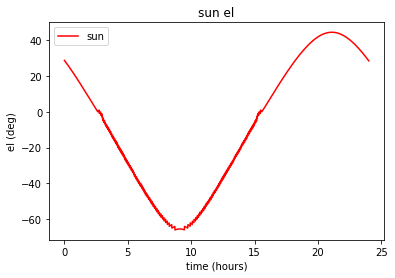

In [13]:


#figure()
plot(times, elsun, 'r-',label='sun')
#plot(times, elmoon, 'b-',label='moon')
title('sun el')
xlabel('time (hours)')
ylabel('el (deg)')
legend()

#figure()
#plot(times, azsun, 'r-',label='sun')
##plot(times, azmoon, 'b-',label='moon')
#title('sun/moon az')
#xlabel('time (hours)')
#ylabel('az (deg)')
#legend()
'''
figure()
dist = np.sqrt((((azsun - azmoon)**2) + ((elsun - elmoon)**2))) 
plot(times, dist, 'r-',label='distance')
title('sun/moon distance apart')
xlabel('time (hours)')
ylabel('distance (deg)')
legend()
'''

In [324]:
azs, els = getpointing('Greenland', 'Sun', datetime.datetime.utcnow())
print datetime.datetime.utcnow()
print azs, els

2018-08-07 11:39:29.548000
129.657305556 28.1718333333


In [323]:
print 479 % 360

119


In [154]:
ra = (5. + 34./60. + 31.94/3600.)*360./24.
dec = 22 + 52.2/3600.

azt, elt = planets.radec_to_azel(ra, dec, 'Greenland', datetime.datetime.utcnow())


print ra, dec
print azt, elt

83.6330833333 22.0145
268.305836314 23.6730372224


In [143]:
ra = (5. + 34./60. + 31.94/3600.)*360./24.
dec = 22 + 52.2/3600.

hours = 4
sph = 60
samples = hours*sph
times = np.linspace(0., hours, samples)

aztau = []
eltau = []

for t in times:
    #azt, elt = getpointing('Greenland', [ra, dec, 'RADEC'], datetime.datetime.utcnow()+timedelta(0, t*3600.))
    azt, elt = planets.radec_to_azel(ra, dec, 'Greenland', datetime.datetime.utcnow()+timedelta(0, t*3600.))
    aztau.append(azt)
    eltau.append(elt)

In [145]:
figure()
plot(times, aztau, 'g-')
title('tau a az')
xlabel('time (hours)')
ylabel('az (deg)')

figure()
plot(times, eltau, 'g-')
title('tau a el')
xlabel('time (hours)')
ylabel('el (deg)')

figure()
dist = np.sqrt((((azsun - aztau)**2) + ((elsun - eltau)**2))) 
plot(times, dist, 'r-',label=' tau/sun distance')
xlabel('time (hours)')
ylabel('distance (deg)')

dist2 = np.sqrt((((aztau - azmoon)**2) + ((eltau - elmoon)**2))) 
plot(times, dist2, 'g-',label='tau/moon distance')
xlabel('time (hours)')
ylabel('distance (deg)')
legend()

In [136]:
print np.asarray(aztau).min(), np.asarray(aztau).max()

256.434676159 256.483998831


In [131]:
print np.asarray(aztau).min(), np.asarray(aztau).max()

255.168941867 311.664156084
